In [1]:
import sys
import os, glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import gc
import collections
import scipy
from sklearn.metrics import mean_squared_error

In [5]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
rmse_results_folder = 'rmse_grid_220911/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
inFilesDir = inDirName+interim_data_folder+rmse_results_folder

## Input Files

In [6]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
%%time
# Drop all NaN-valued grid points
flux_clean = flux_clean.dropna('time',how='all')
flux_clean = flux_clean.dropna('y',how='all')
flux_clean = flux_clean.dropna('x',how='all')
flux_clean = flux_clean.drop("month")

In [ ]:
%%time
model = EOF(flux_clean)
model.solve()
xeofs_eofs = model.eofs()
xeofs_pcs = model.pcs()
xeofs_n_modes = model.n_modes

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = xeofs_pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,xeofs_pcs.shape[0],xeofs_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(xeofs_n_modes):
        fl = xeofs_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization i, mode: {}'.format(m))

In [ ]:
rmse_grid_1500 = xr.open_dataset("rmse_grid_ALLEOFS.nc")
rmse_grid_1500 = rmse_grid_1500.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()

colorbarmax = np.nanmax([rmse_grid_1500])
colorbarmin = np.nanmin([rmse_grid_1500])

rmse_grid_1500.plot(cmap="YlGn",vmax = colorbarmax, vmin = colorbarmin, cbar_kwargs={"label": "RMSE"})
plt.title("RMSE when reconstructed data includes all EOFs")
plt.savefig("rmse_grid_ALLEOFS.png")

In [7]:
inFilesResultsDir = inFilesDir+"results/"
inFilesResultsDir

'/Users/smurugan9/research/aislens/aislens_emulation/data/interim/rmse_grid_220911/results/'

In [59]:
from parse import parse

In [ ]:
rmse_grid = np.empty((1500,457,552))
rmse_grid = xr.DataArray(rmse_grid,coords=datatmp.coords,dims = datatmp.dims,attrs=datatmp.attrs)
for file in sorted(glob.glob(inFilesResultsDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesResultsDir+inFileName).__xarray_dataarray_variable__
    #ds = ds.where(ds>0)
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    t = parse(pattern, inFileName)
    mode = int(t[0])
    print("assigning data to mode {}".format(mode))
    rmse_grid[mode-1,:,:] = ds

In [61]:
rmse_grid

<xarray.DataArray (mode: 1500, y: 457, x: 552)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat          (y, x) float64 dask.array<chunksize=(457, 552), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(457, 552), meta=np.ndarray>
  * x            (x) float64 -2.69e+06 -2.68e+06 -2.67e+06 ... 2.81e+06 2.82e+06
  * y            (y) float64 -2.32e+06 -2.31e+06 -2.3e+06 ... 2.23e+06 2.24e+06
    spatial_ref  int64 0
  * mode         (mode) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499

In [62]:
rmse_grid.to_netcdf(inFilesResultsDir+"rmse_grid.nc")

In [74]:
rmseidxmin = rmse_grid.idxmin('mode')

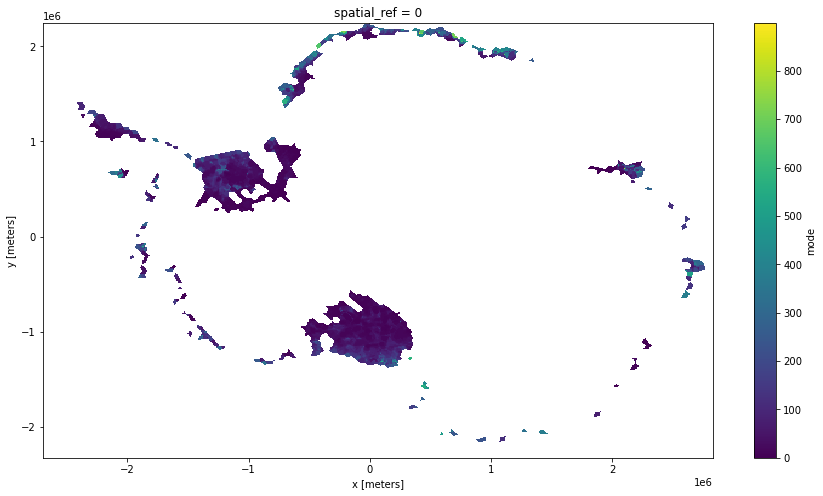

In [75]:
plt.figure(figsize=(15,8))
rmseidxmin.plot()

In [ ]:
#rmse_grid = np.empty((1500,457,552))
#rmse_grid = xr.DataArray(rmse_grid,coords=ds.coords,dims = ds.dims,attrs=ds.attrs)
for file in sorted(glob.glob(inFilesDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesDir+inFileName).__xarray_dataarray_variable__
    ds = ds.where(ds>0)
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    t = parse(pattern, inFileName)
    mode = t[0]
    numStr = mode.zfill(4)
    #numStr = int(numStr)
    print("mode {}".format(numStr))
    ds.to_netcdf(inFilesDir+"results/"+"rmse_grid_comparisons_EOF_{}.nc".format(numStr))

In [135]:
(path, inFileName) = os.path.split("rmse_grid_comparisons_EOF_1420.nc")

In [129]:
import glob, os
from parse import parse

In [137]:
pattern = 'rmse_grid_comparisons_EOF_{}.nc'
t = parse(pattern, inFileName)
int(t[0])

1420

In [51]:
datatmp = xr.open_mfdataset(inFilesDir+"results/"+"rmse_grid_comparisons_EOF_*.nc", combine="nested", concat_dim="mode")
datatmp = datatmp.assign_coords(mode=('mode',datatmp.mode.values))


In [54]:
datatmp = datatmp.__xarray_dataarray_variable__

In [ ]:
ds.to_netcdf(inFilesDir+"rmse_grid.nc")

In [292]:
pattern = 'rmse_grid_comparisons_EOF_{}.nc'
inFileName = 'rmse_grid_comparisons_EOF_0001.nc'
m = parse(pattern, inFileName)
m[0]

'0001'

In [ ]:
%%time
for file in sorted(glob.glob(inFilesResultsDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesResultsDir+inFileName).__xarray_dataarray_variable__
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    m = parse(pattern, inFileName)
    print("mode {}".format(m[0]))
    ds.plot(cbar_kwargs={"label": "RMSE"})
    plt.title("PSD Comparison RMSE at Mode = {}".format(m[0]))
    plt.savefig(inFilesResultsDir+"figures/"+"rmse_grid_comparisons_EOF_{}.png".format(m[0]))
    plt.close()

Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 0222')

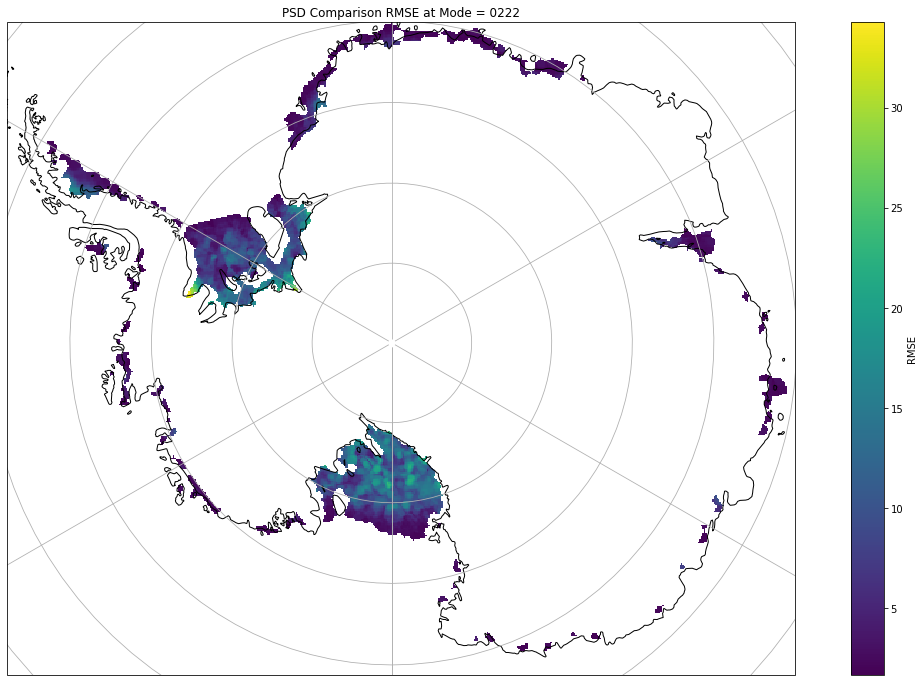

In [48]:
nmode = '0222'
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
#dsn = dsn.where(dsn>0.00000000000000000001)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

In [47]:
modes = list(range(222,223))
for mode in modes:
    nmode = str(mode).zfill(4)
    #plt.figure(figsize=(20,12))
    #ax = plt.axes(projection=ccrs.SouthPolarStereo())
    #ax.coastlines()
    #ax.gridlines()
    dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
    dsn = dsn.__xarray_dataarray_variable__
    dsn = dsn.where(dsn>0.00000000000000000001)
    dsn.to_netcdf(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}_n.nc".format(nmode))
    #dsn = dsn.where(dsn<200)
    #dsn.plot(cbar_kwargs={"label": "RMSE"})
    #plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 0002')

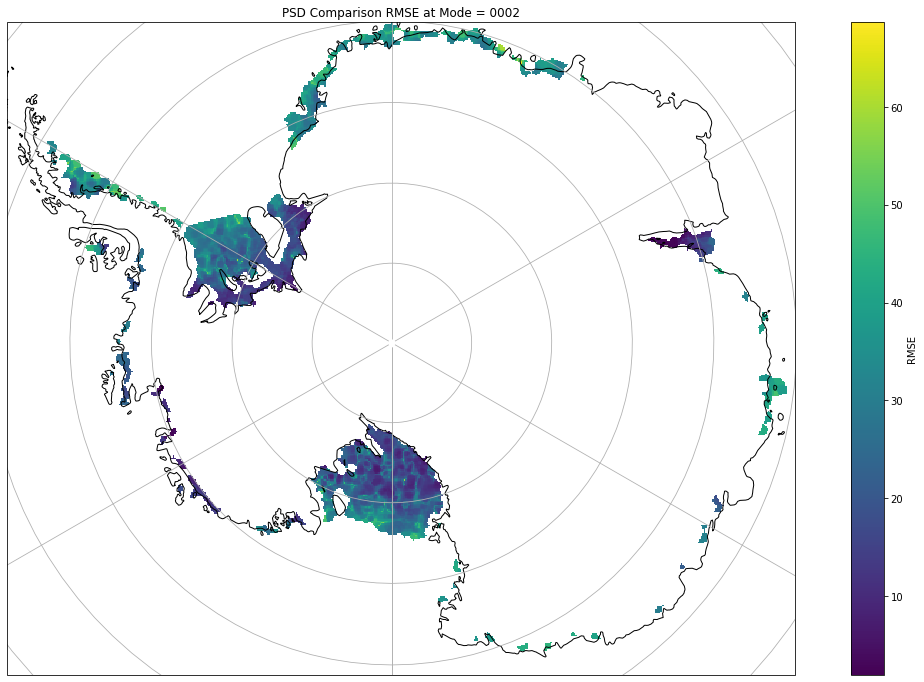

In [67]:
nmode = '0002'
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset("rmse_mode_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
dsn = dsn.where(dsn>0.00000000000000000001)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 222')

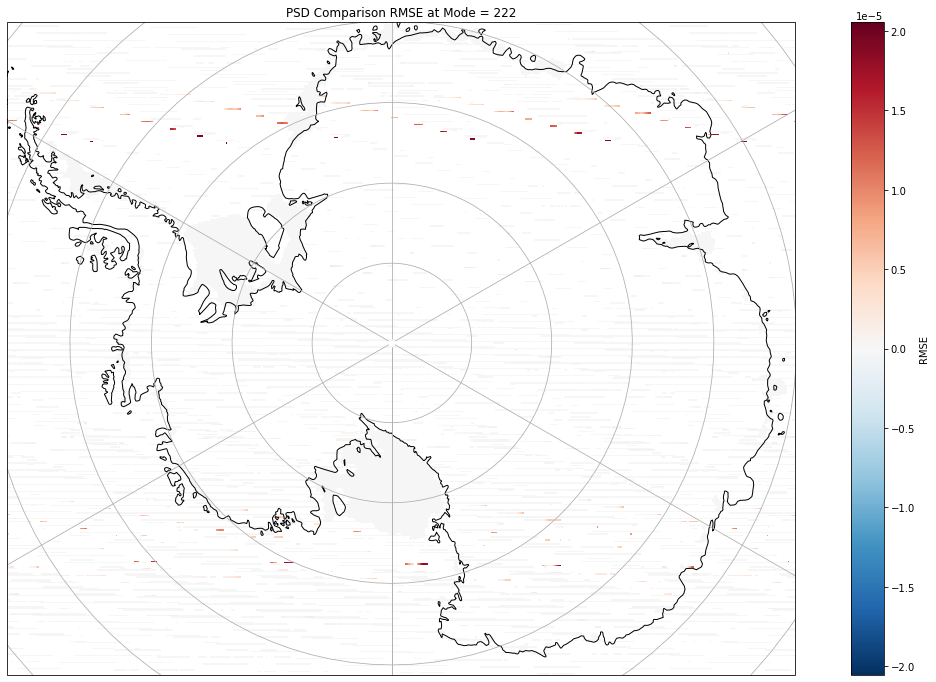

In [30]:
nmode = 222
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset(inFilesDir+"rmse_grid_comparisons_EOF_NEW_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
#dsn = dsn.where(dsn>0)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

In [ ]:
xeofs_modes = list(range(206,223)) 
for mode in xeofs_modes:
    print(mode)

In [235]:
nmode = '1500'
#plt.figure(figsize=(25,12))
#ax = plt.axes(projection=ccrs.SouthPolarStereo())
#ax.coastlines()
#ax.gridlines()

dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
#dsn = xr.open_dataset("rmse_grid_comparisons_EOF_01_full.nc")
dsn = dsn.__xarray_dataarray_variable__

#colorbarmax = np.nanmax([dsn])
#colorbarmin = np.nanmin([dsn])
dsn = dsn.where(dsn>0.0000000001)
dsn = dsn.where(dsn<200)
dsn.to_netcdf(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}_copy.nc".format(nmode))
#dsn.plot(
    #vmax = colorbarmax, 
    #vmin = colorbarmin
#    )

In [ ]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()

data = rmse_grid[556,:,:]
#data = data.where(data>0)
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])

data.plot(cmap="YlGn",vmax = colorbarmax, vmin = colorbarmin, cbar_kwargs={"label": "RMSE"})
plt.title("RMSE when reconstructed data")
#plt.savefig("rmse_grid_ALLEOFS.png")

Text(0.5, 1.0, 'Minimum RMSE values across spatial grid')

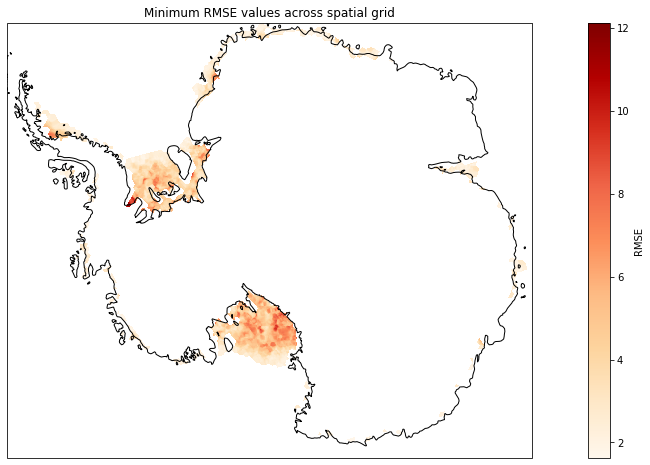

In [94]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
#ax.gridlines()

data = ds.min(dim="mode")
data = data.where(data>0)
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])

data.plot(cmap="OrRd",
          #vmax = colorbarmax,
          #vmin = colorbarmin,
          cbar_kwargs={"label": "RMSE"}
         )
plt.title("Minimum RMSE values across spatial grid")
#plt.savefig("rmse_grid_ALLEOFS.png")

Text(0.5, 1.0, 'Mode # for minimum RMSE values across spatial grid')

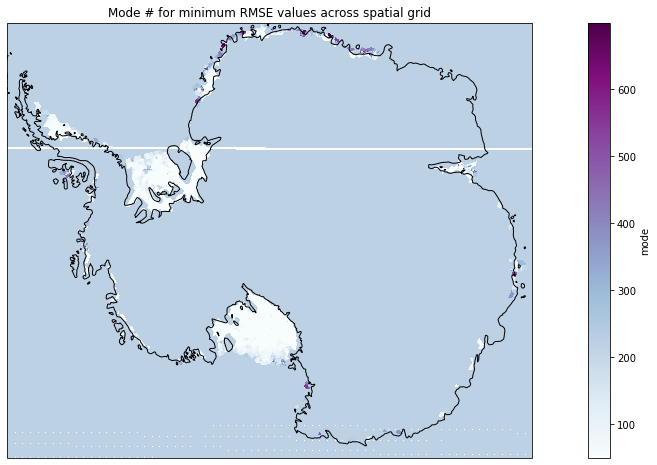

In [279]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
#ax.gridlines()

data = rmse_grid[50:700].idxmin(dim="mode")
#data = data.where(data>0.0001)
colorbarmax = np.nanmax([data])/3
colorbarmin = np.nanmin([data])

data.plot(cmap="BuPu",
          #vmax = colorbarmax,
          #vmin = colorbarmin,
          #cbar_kwargs={"label": "RMSE"}
         )
plt.title("Mode # for minimum RMSE values across spatial grid")
#plt.savefig("rmse_grid_ALLEOFS.png")

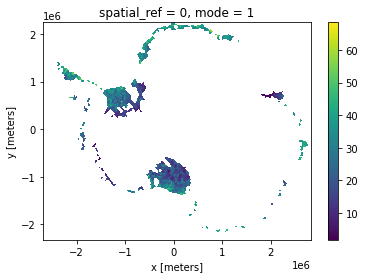

In [284]:
rm = rmse_grid[1,:,:]
rm.plot()

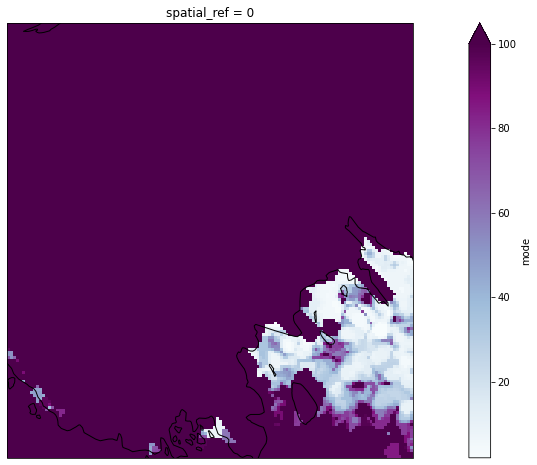

In [195]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
data[100:250,130:270].plot(cmap="BuPu",
          vmax = 100
          #vmin = colorbarmin,
          #cbar_kwargs={"label": "RMSE"}
         )

In [ ]:
data.to_netcdf(inFilesDir+"min_rmse_EOF_grid.nc")

In [ ]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])
data.plot(cmap="BuPu",
          vmax = colorbarmax,
          vmin = colorbarmin,
         )
plt.title("Mode # for minimum RMSE values across spatial grid")

In [110]:
eof_minrmse = ds.idxmin(dim="mode")
minrmse = ds.min(dim="mode")
#allrec = ds[943,:,:]

In [302]:
eof_minrmse = rmse_grid[0:205].idxmin(dim="mode")
minrmse = rmse_grid[0:205].min(dim="mode")
#allrec = ds[943,:,:]

In [303]:
eof_minrmse = eof_minrmse.where(eof_minrmse>0)
minrmse = minrmse.where(minrmse>0)
#allrec = allrec.where(allrec>0)

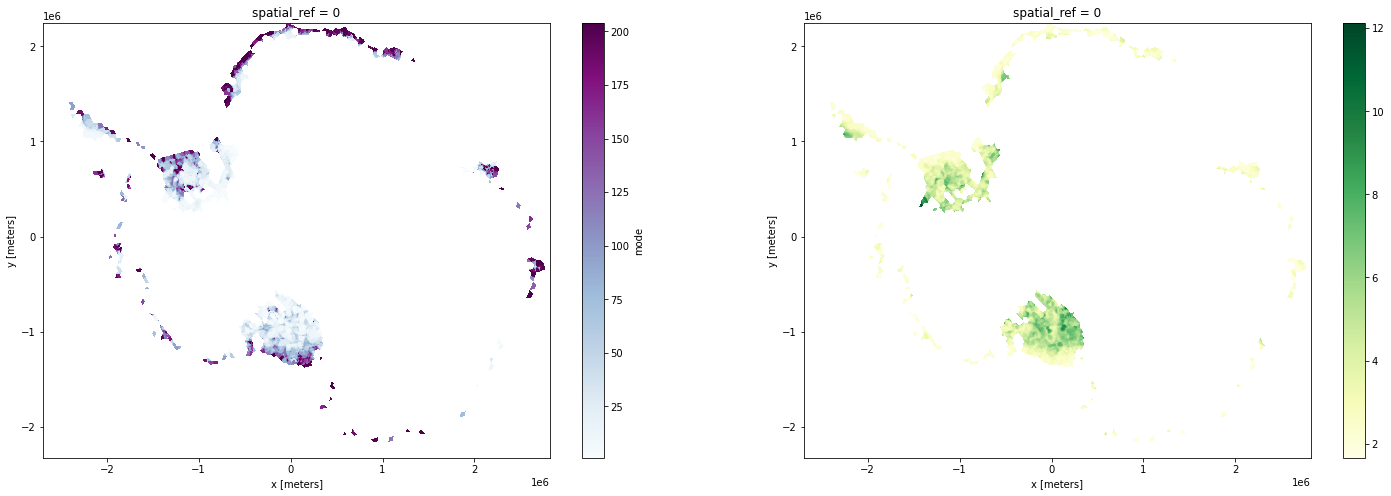

In [304]:
plt.figure(figsize=(25,8))
plt.axes(projection=ccrs.SouthPolarStereo())
#colorbarmax = np.nanmax([data])
#colorbarmin = np.nanmin([data])

plt.subplot(121)
#plt.axes(projection=ccrs.SouthPolarStereo())
eof_minrmse.plot(cmap="BuPu")

plt.subplot(122)
#ax2 = plt.axes(projection=ccrs.SouthPolarStereo())
#ax2.coastlines()
#ax2.gridlines()
minrmse.plot(cmap="YlGn")

#plt.subplot(133)
#ax3 = plt.axes(projection=ccrs.SouthPolarStereo())
#ax3.coastlines()
#ax3.gridlines()
#allrec.plot(cmap="YlGn")

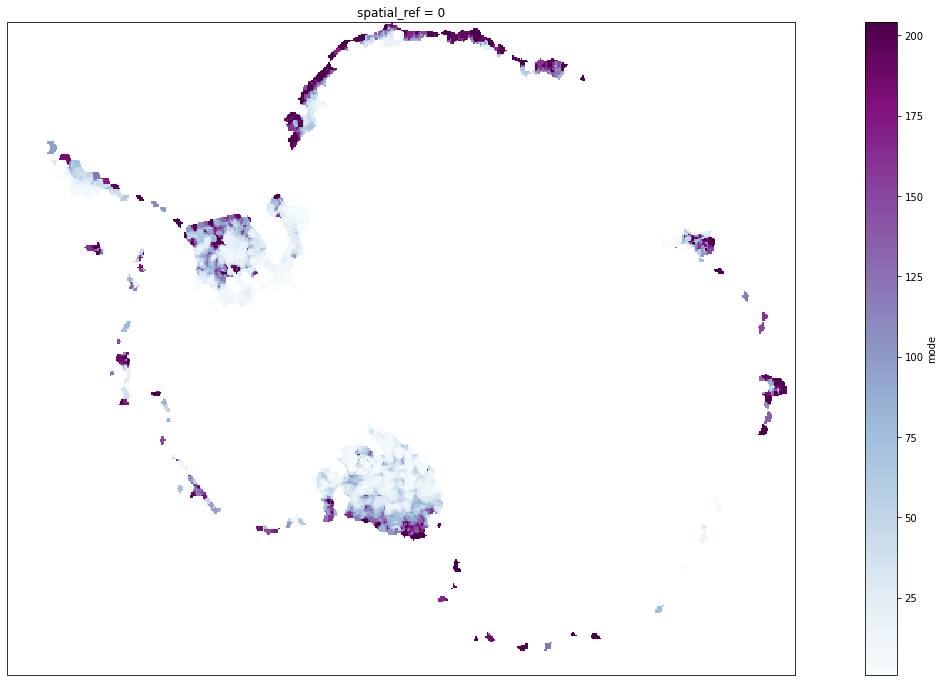

In [305]:
plt.figure(figsize=(25,12))
plt.axes(projection=ccrs.SouthPolarStereo())
eof_minrmse.plot(cmap="BuPu")

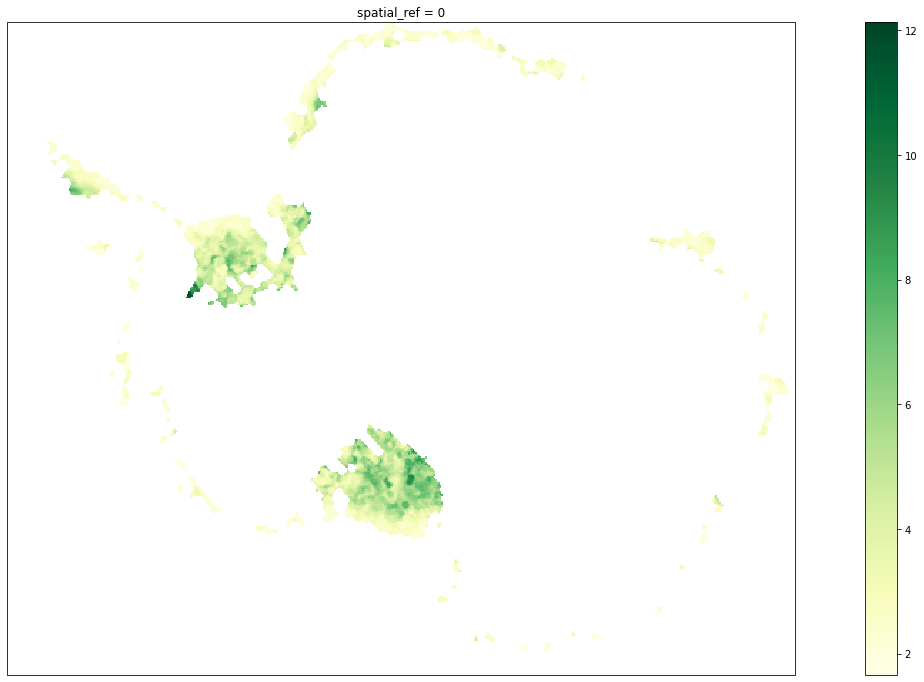

In [306]:
plt.figure(figsize=(25,12))
plt.axes(projection=ccrs.SouthPolarStereo())
minrmse.plot(cmap="YlOrRd", vmax = 30, vmin = 0)

In [ ]:
plt.figure(figsize=(30,12))
plt.axes(projection=ccrs.SouthPolarStereo())

plt.subplot(131)
eof_minrmse.plot(cmap="BuPu", 
#                 vmax = 30, 
#                 vmin = 0
                )

plt.subplot(132)
minrmse.plot(cmap="YlOrRd", 
                 vmax = 24, 
                 vmin = 0
                )

plt.subplot(133)
dsa = xr.open_dataset(inFilesResultsDir+'rmse_grid_comparisons_EOF_1500.nc')
dsa = dsa.__xarray_dataarray_variable__
#plt.axes(projection=ccrs.SouthPolarStereo())
dsa.plot(cmap="YlOrRd", 
         vmax = 24, 
         vmin = 0
        )

In [319]:
eof_minrmse.to_netcdf("eof_minrmse205.nc")
minrmse.to_netcdf("minrmse205.nc")

In [320]:
eof_minrmse205 = xr.open_dataset("eof_minrmse205.nc")
minrmse205 = xr.open_dataset("minrmse205.nc")

In [326]:
eof_minrmse205 = eof_minrmse205.mode
minrmse205 = minrmse205.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(32,8))
plt.axes(projection=ccrs.SouthPolarStereo())

plt.subplot(131)
eof_minrmse205.plot(cmap="BuPu", 
#                 vmax = 30, 
#                 vmin = 0
                )

plt.subplot(132)
minrmse205.plot(cmap="YlOrRd", 
                 vmax = 24, 
                 vmin = 0
                )

plt.subplot(133)
dsa = xr.open_dataset(inFilesResultsDir+'rmse_grid_comparisons_EOF_1500.nc')
dsa = dsa.__xarray_dataarray_variable__
#plt.axes(projection=ccrs.SouthPolarStereo())
dsa.plot(cmap="YlOrRd", 
         vmax = 24, 
         vmin = 0
        )